# Analysis

### *analysing the code analysing* &#x1F575;

## Libraries
---
Importing **libraries** and abbreviating **functions**:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize, ListedColormap
import matplotlib.colorbar as colorbar
import matplotlib.gridspec as gridspec
from matplotlib.widgets import Slider
import matplotlib.animation as animation
import matplotlib as mat
import os
import os.path as op
from scipy.stats import gaussian_kde
from matplotlib import font_manager as fm
import seaborn as sea
import statsmodels.api as sm
from scipy.interpolate import make_interp_spline
from scipy.stats import rayleigh, norm
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.signal import savgol_filter
from peregrin.scripts import PlotParams, FilesAndFolders

## Input and Output paths, Files, Folders
---
### Input and Output paths
Defining the data **input** - assigning the .csv data file's path to a variable "input_file". *If a folder on the Bryjalab server is selected, the user must be logged in while running the script. Also, just a reminder not to forget about activating the VPN connection when working from home ;)*

Defining the analysis's **output** - assigning a folder path to a variable "save_path" into which all the files created will be saved.

In [2]:
# input file path:
input_file = r"Z:\Shared\bryjalab\users\Branislav\Collagen Migration Assay DATA\data 23-7-24\run1\position_4!\C2-position_spots.csv"

# save path:
save_path = r"Z:\Shared\bryjalab\users\Branislav\Collagen Migration Assay DATA\data 23-7-24\run1\position_4!\analysed"

---
### Loading the input
Loading the *.csv* **input file** as a DataFrame into the "df" variable:

In [3]:
df = pd.read_csv(input_file)

---
### *Keeping it tidy*
*While working on the script, it may happen often that you'd like to modify the output directories, change titles or names of the files created and saved, or you might even fall out of love with certain plots, removing their code from the script completely. So with keeping this in mind, it is to be expected that constantly remodeling and rerunning the analysis on the same dataset will cause chaos.. For this reason, there is a **very sketchy function** you can use, if you dare :smiling_imp:.*

This ***very sketchy function*** **deletes all files** - though not directories *(folders):*

In [4]:
FilesAndFolders.clean('folder')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'folder'

## Processing of the data set, Functions, Calculations
---
### Unnecessary floats
Some of the data in the *.csv* file, which I extract from trackmate, are unnecessarily floating point numbers. The columns obtaining unnecessary float data are defined in this list:

In [5]:
unneccessary_float_columns = [ # Definition of unneccesary float columns in the df which are to be convertet to integers
    'ID', 
    'TRACK_ID', 
    'POSITION_T', 
    'FRAME'
    ]

### Like butter
The dataset's structure itself is also very ragged, therefore the "butter" function is defined with intention of **making further processing and workflow smooth**. It basically deals with certain obstacles right at the start and at once, so that they don't get in the way later. 

In [6]:
def butter(df, float_columns): # Smoothing the raw dataframe

    # Drop rows with non-numeric values and convert columns to numeric
    df = df.apply(pd.to_numeric, errors='coerce').dropna(subset=['POSITION_X', 'POSITION_Y', 'POSITION_Z', 'POSITION_T'])

    # Ensure the DataFrame is sorted by TRACK_ID and POSITION_T (time)
    df = df.sort_values(by=['TRACK_ID', 'POSITION_T'])

    # Load the data into a DataFrame
    df = pd.DataFrame(df)    

    # Reset the df index
    df = df.reset_index(drop=True)

    # Reflect y-coordinates around the midpoint for the directionality to be accurate, according to the microscope videos
    y_mid = (df['POSITION_Y'].min() + df['POSITION_Y'].max()) / 2
    df['POSITION_Y'] = 2 * y_mid - df['POSITION_Y']

    # The dataset itself has a very chaotic, multirow column title "system". Therefore in this list are again defined columns, which from now on will be used for consistency
    df.columns = [
        'LABEL', 
        'ID', 
        'TRACK_ID', 
        'QUALITY', 
        'POSITION_X', 
        'POSITION_Y', 
        'POSITION_Z', 
        'POSITION_T', 
        'FRAME', 
        'RADIUS', 
        'VISIBILITY', 
        'MANUAL_SPOT_COLOR', 
        'MEAN_INTENSITY_CH1', 
        'MEDIAN_INTENSITY_CH1', 
        'MIN_INTENSITY_CH1', 
        'MAX_INTENSITY_CH1', 
        'TOTAL_INTENSITY_CH1', 
        'STD_INTENSITY_CH1', 
        'EXTRACK_P_STUCK', 
        'EXTRACK_P_DIFFUSIVE', 
        'CONTRAST_CH1', 
        'SNR_CH1'
        ]

    # Droping all NaN (non numeric) values, also dropping whole columns with NaN values
    df = df.dropna(axis=1)

    # Conversion of unnecessary floats to integers (they are defined in the list in the cell above)
    df[float_columns] = df[float_columns].astype(int)

    return df

## Functions and calculations &#x1F3D7;
---
&#x1F6A7; *waiting to be described* &#x1F6A7;

In [7]:
def calculate_traveled_distances_for_each_cell_per_frame(df):

    # Calculate distances between consecutive frames
    if df.empty:
            return np.nan
    
    def distance_per_frame(group):
        group = group.copy()
        # Compute the Euclidean distance between consecutive frames
        group['DISTANCE'] = np.sqrt(
            (group['POSITION_X'].diff() ** 2) +
            (group['POSITION_Y'].diff() ** 2)
        )
        return group
    
    # Ensure TRACK_ID is not used as index in grouping; Calculate distances; Drop rows where DISTANCE is NaN (first frame of each TRACK_ID group)
    result_df = df.reset_index(drop=True).groupby('TRACK_ID', as_index=False).apply(distance_per_frame).dropna(subset='DISTANCE')

    return pd.DataFrame(result_df)

In [8]:
def calculate_track_length_traveled_for_each_cell(df):

    # Convert 'Track ID' to numeric (if it's not already)
    df['TRACK_ID'] = pd.to_numeric(df['TRACK_ID'], errors='coerce')
    
    # Making sure that no empty lines are created in the DataFrame
    if df.empty:
        return np.nan
    
    # Sum distances per Track ID
    track_length_per_cell = df.groupby('TRACK_ID')['DISTANCE'].sum().reset_index()

    # Rename columns for clarity
    track_length_per_cell.columns = ['TRACK_ID', 'TRACK_LENGTH']

    # Return the results
    return pd.DataFrame(track_length_per_cell)

In [9]:
def calculate_net_distance_traveled_for_each_cell(df):

    # Convert 'TRACK_ID' to numeric (if it's not already)
    df['TRACK_ID'] = pd.to_numeric(df['TRACK_ID'], errors='coerce')

    # Get the start and end positions for each track, calculate the enclosed distance and group by 'TRACK_ID'
    def calculate_distance(start, end):
        return np.sqrt((end[0] - start[0])**2 + (end[1] - start[1])**2)
    
    def net_distance_per_track(track_df):
        if track_df.empty:
            return np.nan
        start_position = track_df.iloc[0][['POSITION_X', 'POSITION_Y']].values
        end_position = track_df.iloc[-1][['POSITION_X', 'POSITION_Y']].values
        return calculate_distance(start_position, end_position)

    net_distances = df.groupby('TRACK_ID').apply(net_distance_per_track).reset_index(name='NET_DISTANCE')

    # Return the results
    return pd.DataFrame(net_distances)

In [10]:
def calculate_confinement_ratio_for_each_cell_and_aggregate_with_track_lengths_net_distances(df):
    # Calculate the confinement ratio
    df['CONFINEMENT_RATIO'] = df['NET_DISTANCE'] / df['TRACK_LENGTH']
    Track_stats_df = df[['TRACK_ID','CONFINEMENT_RATIO']]
    return pd.DataFrame(Track_stats_df)

In [11]:
def calculate_distances_per_frame(df):
    min_distance_per_frame = df.groupby('POSITION_T')['DISTANCE'].min().reset_index()
    min_distance_per_frame.rename(columns={'DISTANCE': 'min_DISTANCE'}, inplace=True)
    max_distance_per_frame = df.groupby('POSITION_T')['DISTANCE'].max().reset_index()
    max_distance_per_frame.rename(columns={'DISTANCE': 'max_DISTANCE'}, inplace=True)
    mean_distances_per_frame = df.groupby('POSITION_T')['DISTANCE'].mean().reset_index()
    mean_distances_per_frame.rename(columns={'DISTANCE': 'MEAN_DISTANCE'}, inplace=True)
    std_deviation_distances_per_frame = df.groupby('POSITION_T')['DISTANCE'].std().reset_index()
    std_deviation_distances_per_frame.rename(columns={'DISTANCE': 'STD_DEVIATION_distances'}, inplace=True)
    median_distances_per_frame = df.groupby('POSITION_T')['DISTANCE'].median().reset_index()
    median_distances_per_frame.rename(columns={'DISTANCE': 'MEDIAN_DISTANCE'}, inplace=True)
    merge = pd.merge(min_distance_per_frame, max_distance_per_frame, on='POSITION_T')
    merge = pd.merge(merge, mean_distances_per_frame, on='POSITION_T')
    merge = pd.merge(merge, std_deviation_distances_per_frame, on='POSITION_T')
    merged = pd.merge(merge, median_distances_per_frame, on='POSITION_T')
    return pd.DataFrame(merged)

In [12]:
def calculate_direction_of_travel_for_each_cell_per_frame(df):

    directions = []
    for track_id in df['TRACK_ID'].unique():
        track_data = df[df['TRACK_ID'] == track_id]
        dx = track_data['POSITION_X'].diff().iloc[1:]
        dy = track_data['POSITION_Y'].diff().iloc[1:]
        rad = (np.arctan2(dy, dx))
        for i in range(len(rad)):
            directions.append({
                'TRACK_ID': track_id, 
                'POSITION_T': track_data['POSITION_T'].iloc[i + 1], 
                'DIRECTION_RAD': rad.iloc[i]
                })
    return pd.DataFrame(directions)

In [13]:
def calculate_directions_per_cell(df):
    mean_direction_rad = df.groupby('TRACK_ID')['DIRECTION_RAD'].apply(lambda angles: np.arctan2(np.mean(np.sin(angles)), np.mean(np.cos(angles))))
    mean_direction_deg = np.degrees(mean_direction_rad) % 360
    std_deviation_rad = df.groupby('TRACK_ID')['DIRECTION_RAD'].apply(lambda angles: np.sqrt(np.mean(np.cos(angles))**2 + np.mean(np.sin(angles))**2))
    std_deviatin_deg = np.degrees(std_deviation_rad) % 360
    median_direction_rad = df.groupby('TRACK_ID')['DIRECTION_RAD'].apply(lambda angles: np.arctan2(np.median(np.sin(angles)), np.median(np.cos(angles))))
    median_direction_deg = np.degrees(median_direction_rad) % 360
    return pd.DataFrame({
        'TRACK_ID': mean_direction_rad.index, 
        'MEAN_DIRECTION_DEG': mean_direction_deg, 
        'STD_DEVIATION_DEG': std_deviatin_deg, 
        'MEDIAN_DIRECTION_DEG': median_direction_deg, 
        'MEAN_DIRECTION_RAD': mean_direction_rad, 
        'STD_DEVIATION_RAD': std_deviation_rad, 
        'MEADIAN_DIRECTION_RAD': median_direction_rad
        }).reset_index(drop=True)

In [14]:
def calculate_absolute_directions_per_frame(df):
    grouped = df.groupby('POSITION_T')
    mean_direction_rad = grouped['DIRECTION_RAD'].apply(lambda angles: np.arctan2(np.mean(np.sin(angles)), np.mean(np.cos(angles))))
    mean_direction_deg = np.degrees(mean_direction_rad) % 360
    std_deviation_rad = grouped['DIRECTION_RAD'].apply(lambda angles: np.sqrt(np.mean(np.cos(angles))**2 + np.mean(np.sin(angles))**2))
    std_deviatin_deg = np.degrees(std_deviation_rad) % 360
    median_direction_rad = grouped['DIRECTION_RAD'].apply(lambda angles: np.arctan2(np.median(np.sin(angles)), np.median(np.cos(angles))))
    median_direction_deg = np.degrees(median_direction_rad) % 360
    return pd.DataFrame({
        'POSITION_T': mean_direction_rad.index, 
        'MEAN_DIRECTION_DEG_abs': mean_direction_deg, 
        'STD_DEVIATION_DEG_abs': std_deviatin_deg, 
        'MEDIAN_DIRECTION_DEG_abs': median_direction_deg, 
        'MEAN_DIRECTION_RAD_abs': mean_direction_rad, 
        'STD_DEVIATION_RAD_abs': std_deviation_rad, 
        'MEADIAN_DIRECTION_RAD_abs': median_direction_rad
        }).reset_index(drop=True)

In [15]:
def calculate_weighted_directions_per_frame(df):
    def weighted_mean_direction(angles, weights):
        weighted_sin = np.average(np.sin(angles), weights=weights)
        weighted_cos = np.average(np.cos(angles), weights=weights)
        return np.arctan2(weighted_sin, weighted_cos)
    
    def weighted_std_deviation(angles, weights, mean_direction_rad):
        weighted_sin = np.average(np.sin(angles - mean_direction_rad), weights=weights)
        weighted_cos = np.average(np.cos(angles - mean_direction_rad), weights=weights)
        return np.sqrt(weighted_sin**2 + weighted_cos**2)
    
    def weighted_median_direction(angles, weights):
        # Weighted median approximation: using percentile function from scipy
        from scipy.stats import cumfreq
        sorted_angles = np.sort(angles)
        sorted_weights = np.array(weights)[np.argsort(angles)]
        cumsum_weights = np.cumsum(sorted_weights)
        midpoint = np.sum(weights) / 2
        idx = np.searchsorted(cumsum_weights, midpoint)
        return sorted_angles[idx]

    grouped = df.groupby('POSITION_T')
    
    # Compute weighted metrics
    mean_direction_rad = grouped.apply(lambda x: weighted_mean_direction(x['DIRECTION_RAD'], x['DISTANCE'])).reset_index(level=0, drop=True)
    mean_direction_deg = np.degrees(mean_direction_rad) % 360
    
    std_deviation_rad = grouped.apply(lambda x: weighted_std_deviation(x['DIRECTION_RAD'], x['DISTANCE'], weighted_mean_direction(x['DIRECTION_RAD'], x['DISTANCE']))).reset_index(level=0, drop=True)
    std_deviation_deg = np.degrees(std_deviation_rad) % 360
    
    median_direction_rad = grouped.apply(lambda x: weighted_median_direction(x['DIRECTION_RAD'], x['DISTANCE'])).reset_index(level=0, drop=True)
    median_direction_deg = np.degrees(median_direction_rad) % 360
    
    result_df = pd.DataFrame({
        'POSITION_T': mean_direction_rad.index,
        'MEAN_DIRECTION_DEG_weight': mean_direction_deg,
        'STD_DEVIATION_DEG_weight': std_deviation_deg,
        'MEDIAN_DIRECTION_DEG_weight': median_direction_deg,
        'MEAN_DIRECTION_RAD_weight': mean_direction_rad,
        'STD_DEVIATION_RAD_weight': std_deviation_rad,
        'MEDIAN_DIRECTION_RAD_weight': median_direction_rad
    }).reset_index(drop=True)

    result_df['POSITION_T'] = result_df['POSITION_T'] + 1
    
    return result_df

In [16]:
def calculate_turn_angles_for_each_cell_per_frame(df):
    # Sort the DataFrame by TRACK_ID and POSITION_T to maintain order
    df = df.sort_values(by=['TRACK_ID', 'POSITION_T'])
    
    # Function to compute the angle difference
    def compute_angle_difference(angles):
        # Compute the difference between consecutive angles
        diff = np.degrees(abs(np.diff(abs(angles))))
        return np.concatenate(([0], diff))  # Return the result with a 0 for the first position

    # Apply the function to each TRACK_ID group
    df['ANGLE_TURNED'] = df.groupby('TRACK_ID')['DIRECTION_RAD'].transform(compute_angle_difference)
    
    df = df[['TRACK_ID', 'POSITION_T', 'ANGLE_TURNED']]

    return df

In [17]:
def calculate_angles_per_frame(df):
    min_angle_per_frame = df.groupby('POSITION_T')['ANGLE_TURNED'].min().reset_index()
    min_angle_per_frame.rename(columns={'ANGLE_TURNED': 'min_ANGLE_TURNED'}, inplace=True)
    max_angle_per_frame = df.groupby('POSITION_T')['ANGLE_TURNED'].max().reset_index()
    max_angle_per_frame.rename(columns={'ANGLE_TURNED': 'max_ANGLE_TURNED'}, inplace=True)
    mean_angles_per_frame = df.groupby('POSITION_T')['ANGLE_TURNED'].mean().reset_index()
    mean_angles_per_frame.rename(columns={'ANGLE_TURNED': 'MEAN_ANGLE_TURNED'}, inplace=True)
    std_deviation_angles_per_frame = df.groupby('POSITION_T')['ANGLE_TURNED'].std().reset_index()
    std_deviation_angles_per_frame.rename(columns={'ANGLE_TURNED': 'STD_DEVIATION_angles'}, inplace=True)
    median_angles_per_frame = df.groupby('POSITION_T')['ANGLE_TURNED'].median().reset_index()
    median_angles_per_frame.rename(columns={'ANGLE_TURNED': 'MEDIAN_ANGLE_TURNED'}, inplace=True)
    merge = pd.merge(min_angle_per_frame, max_angle_per_frame, on='POSITION_T')
    merge = pd.merge(merge, mean_angles_per_frame, on='POSITION_T')
    merge = pd.merge(merge, std_deviation_angles_per_frame, on='POSITION_T')
    merged = pd.merge(merge, median_angles_per_frame, on='POSITION_T')
    return pd.DataFrame(merged)

In [18]:
def calculate_number_of_frames_per_cell(spot_stats_df):
    # Count the number of frames for each TRACK_ID in the Spot_stats2_df
    frames_per_track = (spot_stats_df.groupby("TRACK_ID").size().reset_index(name="NUM_FRAMES"))

    return frames_per_track

In [19]:
def calculate_speed(df, variable):

    min_speed_microns_min = df.groupby(variable)['DISTANCE'].min().reset_index()
    min_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_MIN'}, inplace=True)
    max_speed_microns_min = df.groupby(variable)['DISTANCE'].max().reset_index()
    max_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_MAX'}, inplace=True)
    mean_speed_microns_min = df.groupby(variable)['DISTANCE'].mean().reset_index()
    mean_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_MEAN'}, inplace=True)
    std_deviation_speed_microns_min = df.groupby(variable)['DISTANCE'].std().reset_index()
    std_deviation_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_STD_DEVIATION'}, inplace=True)
    median_speed_microns_min = df.groupby(variable)['DISTANCE'].median().reset_index()
    median_speed_microns_min.rename(columns={'DISTANCE': 'SPEED_MEDIAN'}, inplace=True)
    merge = pd.merge(min_speed_microns_min, max_speed_microns_min, on=variable)
    merge = pd.merge(merge, mean_speed_microns_min, on=variable)
    merge = pd.merge(merge, std_deviation_speed_microns_min, on=variable)
    merged = pd.merge(merge, median_speed_microns_min, on=variable)

    return pd.DataFrame(merged)

## Function execution &#x1F3D7;
---
&#x1F6A7; *waiting to be described* &#x1F6A7;

In [25]:
butter_df = butter(df, unneccessary_float_columns)
distances_for_each_cell_per_frame_df = calculate_traveled_distances_for_each_cell_per_frame(butter_df) # Call the funciton to clalculate distances for each cell per frame and create the Spot_statistics .csv file
track_lengths_df = calculate_track_length_traveled_for_each_cell(distances_for_each_cell_per_frame_df) # Calling function to calculate the total distance traveled for each cell from the distances_for_each_cell_per_frame_df
net_distances_df = calculate_net_distance_traveled_for_each_cell(distances_for_each_cell_per_frame_df) # Calling function to calculate the net distance traveled for each cell from the distances_for_each_cell_per_frame_df

direction_for_each_cell_per_frame_df = calculate_direction_of_travel_for_each_cell_per_frame(butter_df) # Call the function to calculate direction_for_each_cell_per_frame_df
Spot_stats1_df = pd.merge(distances_for_each_cell_per_frame_df, direction_for_each_cell_per_frame_df, on=['TRACK_ID','POSITION_T'], how='outer') # Merging track_lengths_df and direction_for_each_cell_per_frame_df into Spot_stats_df

turn_angles_for_each_cell_per_frame = calculate_turn_angles_for_each_cell_per_frame(Spot_stats1_df) # Call function to calculate the turn angle for each cell per frame
Spot_stats2_df = pd.merge(Spot_stats1_df, turn_angles_for_each_cell_per_frame, on=['TRACK_ID','POSITION_T'], how='outer') # Merging Spot_stats1_df and turn_angles_for_each_cell_per_frame into Spot_stats2_df DataFrame
Spot_stats2_df.to_csv(op.join(save_path, 'Spot_stats.csv')) # Saving the Spot_stats2_df DataFrame into a newly created .csv file

directions_per_cell_df = calculate_directions_per_cell(direction_for_each_cell_per_frame_df) # Call the function to calculate directions_per_cell_df
frames_per_track = calculate_number_of_frames_per_cell(Spot_stats2_df)
speeds_per_cell = calculate_speed(Spot_stats2_df, 'TRACK_ID')

Track_stats1_df = pd.merge(track_lengths_df, net_distances_df, on='TRACK_ID', how='outer') # Merge the track_lengths_df and the net_distances_df DataFrames into a new DataFrame: Track_stats1_df
confinement_ratio_per_each_cell = calculate_confinement_ratio_for_each_cell_and_aggregate_with_track_lengths_net_distances(Track_stats1_df) # Call the function to calculate confinement ratios from the Track_statistics1_df and write it into the Track_statistics1_df

Track_stats2_df = pd.merge(Track_stats1_df, directions_per_cell_df, on='TRACK_ID', how='outer') # Merge the Track_stats2_df and the directions_per_cell_df into a new DataFrame: Track_stats3_df
Track_stats3_df = pd.merge(Track_stats2_df, frames_per_track, on='TRACK_ID', how='outer')
Track_stats4_df = pd.merge(Track_stats3_df, speeds_per_cell, on='TRACK_ID', how='outer')
Track_stats4_df.to_csv((op.join(save_path, 'Track_stats.csv')), index=False) # Save the Track_stats created DataFrame into a newly created Track_stats_debugging.csv file

distances_per_frame_df = calculate_distances_per_frame(distances_for_each_cell_per_frame_df) # Call the function to calculate distances_per_frame_df
absolute_directions_per_frame_df = calculate_absolute_directions_per_frame(direction_for_each_cell_per_frame_df) # Call the function to calculate directions_per_frame_df
weighted_directions_per_frame = calculate_weighted_directions_per_frame(Spot_stats1_df) # Call the function tp calculate weighted_directions_per_frame
angles_per_frame = calculate_angles_per_frame(Spot_stats2_df)
speeds_per_frame = calculate_speed(Spot_stats2_df, 'POSITION_T')

Time_stats1_df = pd.merge(distances_per_frame_df, absolute_directions_per_frame_df, on='POSITION_T', how='outer') # Merge the distances_per_frame_df and the directions_per_frame_df into a new DataFrame: Time_stats1_df
Time_stats2_df = pd.merge(Time_stats1_df, weighted_directions_per_frame, on='POSITION_T', how='outer') # Merging Time_stats1_df and weighted_directions_per_frame
Time_stats3_df = pd.merge(Time_stats2_df, speeds_per_frame, on='POSITION_T', how='outer')
Time_stats3_df.to_csv((op.join(save_path, 'Time_stats.csv')), index=False) # Save the Time_stats1_df into a newly created Time_stats_debugging.csv file


C:\Users\modri\AppData\Local\Temp\ipykernel_16436\2170223756.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.reset_index(drop=True).groupby('TRACK_ID', as_index=False).apply(distance_per_frame).dropna(subset='DISTANCE')
C:\Users\modri\AppData\Local\Temp\ipykernel_16436\3859857744.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  net_distances = df.groupby('TRACK_ID').apply(net_distanc

## Thresholding &#x1F3D7;
---
[Function with defined thresholds extracting various dataframes]

&#x1F6A7; *under construction* &#x1F6A7;

In [26]:
def split_dataframe_by_percentiles(df, column_name):
    # Get to know the data frames name
    df_name = [name for name, value in globals().items() if value is df][0]

    # Dictionary to store each DataFrame filtered by percentiles
    dataframes_by_percentile = {}

    # Calculate percentiles and filter the DataFrame for each
    for percentile in range(10, 100, 10):
        threshold_value = df[column_name].quantile(percentile / 100)
        filtered_df = df[df[column_name] > threshold_value]

        # Save the DataFrame
        filename = f'{df_name}_with_{column_name}_thresholded_at_{percentile}th_percentile.csv'
        filtered_df.to_csv(op.join(save_path, filename), index=False)

        # Store in dictionary (optional)
        dataframes_by_percentile[f'threshold_at_{percentile}th_percentile'] = filtered_df

    # Accessing a specific DataFrame for, say, the 30th percentile
    df_thresholded_at_10th_percentile = dataframes_by_percentile['threshold_at_10th_percentile'] # 10th
    df_thresholded_at_20th_percentile = dataframes_by_percentile['threshold_at_20th_percentile'] # 20th
    df_thresholded_at_30th_percentile = dataframes_by_percentile['threshold_at_30th_percentile'] # 30th
    df_thresholded_at_40th_percentile = dataframes_by_percentile['threshold_at_40th_percentile'] # 40th
    df_thresholded_at_50th_percentile = dataframes_by_percentile['threshold_at_50th_percentile'] # 50th
    df_thresholded_at_60th_percentile = dataframes_by_percentile['threshold_at_60th_percentile'] # 60th
    df_thresholded_at_70th_percentile = dataframes_by_percentile['threshold_at_70th_percentile'] # 70th
    df_thresholded_at_80th_percentile = dataframes_by_percentile['threshold_at_80th_percentile'] # 80th
    df_thresholded_at_90th_percentile = dataframes_by_percentile['threshold_at_90th_percentile'] # 90th


    return df_thresholded_at_10th_percentile, df_thresholded_at_20th_percentile, df_thresholded_at_30th_percentile, df_thresholded_at_40th_percentile, df_thresholded_at_50th_percentile, df_thresholded_at_60th_percentile, df_thresholded_at_70th_percentile, df_thresholded_at_80th_percentile, df_thresholded_at_90th_percentile
Track_stats_thresholded_at_10th_percentile, Track_stats_thresholded_at_20th_percentile, Track_stats_thresholded_at_30th_percentile, Track_stats_thresholded_at_40th_percentile, Track_stats_thresholded_at_50th_percentile, Track_stats_thresholded_at_60th_percentile, Track_stats_thresholded_at_70th_percentile, Track_stats_thresholded_at_80th_percentile, Track_stats_thresholded_at_90th_percentile = split_dataframe_by_percentiles(Track_stats3_df, 'NET_DISTANCE')

# You should try: split_dataframe_by_percentiles(df, column_name); column_name = 'NET_DISTANCE', 'TRACK_LENGTH', 'CONFINEMENT_RATIO', 'SPEED_MEDIAN AND OR MEAN, ETC 


## Visualizers, Plots, Histograms &#x1F3D7;
---
&#x1F6A7; *waiting to be described* &#x1F6A7;

---
### Defining the optic parameters
Defining the pixel length, imaging winfow parameters and aspect ratio based on the microscope:

In [27]:
# Definition of micron length per pixel
microns_per_pixel = 0.7381885238402274 # for 10x lens

# Define the desired dimensions in microns
x_min, x_max = 0, (1600 * microns_per_pixel)
y_min, y_max = 0, (1200 * microns_per_pixel)

# Calculate the aspect ratio
aspect_ratio = x_max / y_max

In [28]:
title_size = 18
label_size = 11
figtext_size = 9
compass_annotations_size = 15
figtext_color = 'grey'

---
### Plotting the direction of migration &#x1F3D7;
&#x1F6A7; *under construction* &#x1F6A7; 

<>:94: SyntaxWarning: invalid escape sequence '\i'
<>:94: SyntaxWarning: invalid escape sequence '\i'
C:\Users\modri\AppData\Local\Temp\ipykernel_16436\3406826808.py:94: SyntaxWarning: invalid escape sequence '\i'
  ax.set_title(f'Mean Direction of Travel with Kernel Density Estimate\n$\it{{{subject}}}$', fontsize=title_size)


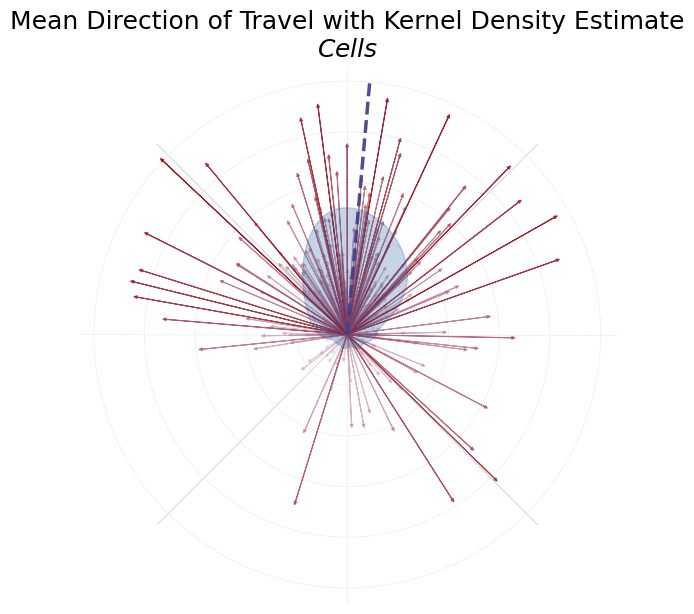

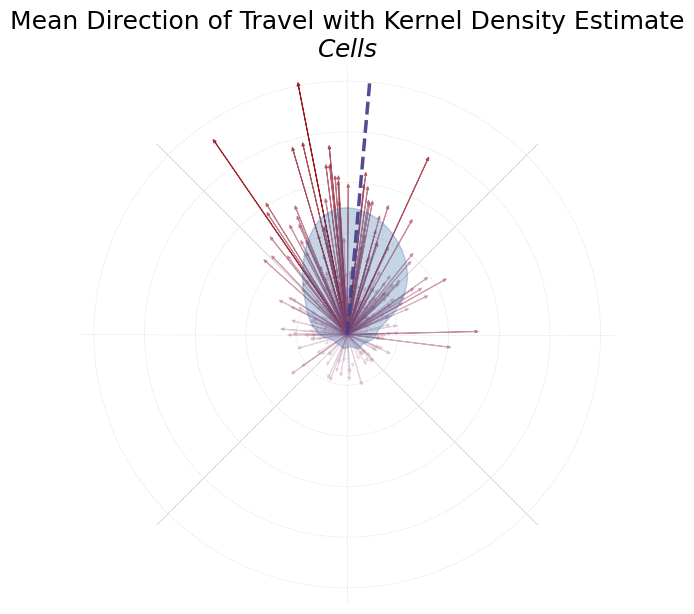

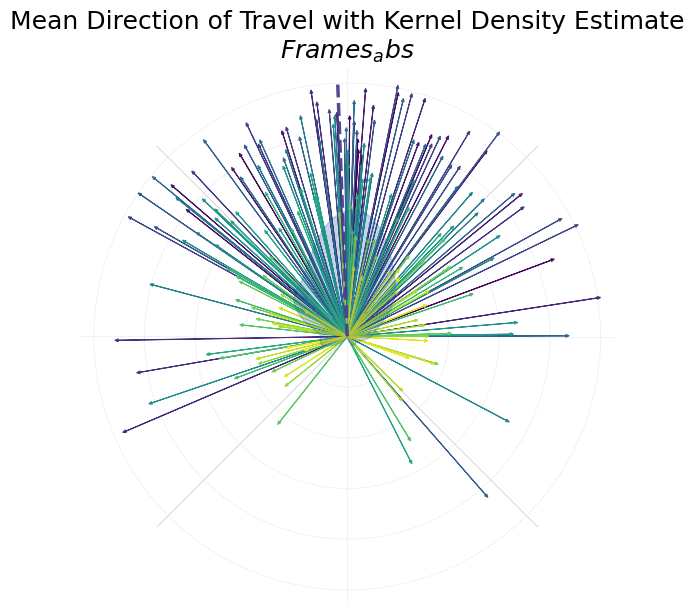

In [29]:
cmap_cells = mcolors.LinearSegmentedColormap.from_list("", ["#9b598910", "#9b181eff"]) #303030
cmap_frames = plt.get_cmap('viridis')

def migration_directions_with_kde_plus_mean(df, metric, subject, scaling_metric, cmap_normalization_metric, cmap, threshold):

    # Recognizing the presence of a threshold
    if threshold == None:
        threshold = '_no_threshold'
    else:
        threshold = '_' + threshold

    df_mean_direction = df[metric]

    # Prepare for KDE plot
    x_kde = np.cos(df_mean_direction)
    y_kde = np.sin(df_mean_direction)
    kde = gaussian_kde([x_kde, y_kde])

    # Define the grid for evaluation
    theta_kde = np.linspace(0, 2 * np.pi, 360)
    x_grid = np.cos(theta_kde)
    y_grid = np.sin(theta_kde)

    # Evaluate the KDE on the grid and normalize
    z_kde = kde.evaluate([x_grid, y_grid])
    z_kde = z_kde / z_kde.max() * 0.5  # Normalize to fit within the radial limit

    # Calculate the mean direction
    mean_direction = np.arctan2(np.mean(y_kde), np.mean(x_kde))

    # Start plotting
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'polar': True})

    # Plot KDE
    ax.plot(theta_kde, z_kde, label='Circular KDE', color='None', zorder=5)
    ax.fill(theta_kde, z_kde, alpha=0.25, color='#1b5a9e', zorder=5)

    # Directional Arrows
    scaling_max = df[scaling_metric].max()

    # Normalization of the color map
    if cmap_normalization_metric == None:
        norm = mcolors.Normalize(vmin=0, vmax=1)
    else:
        normalization_min = df[cmap_normalization_metric].min()
        normalization_max = df[cmap_normalization_metric].max()
        norm = mcolors.Normalize(vmin=normalization_min, vmax=normalization_max)

    # Row itteration
    for _, row in df.iterrows():
        scaling_metrics = row[scaling_metric]
        mean_direction_rad = row[metric]
        arrow_length = scaling_metrics / scaling_max

        if cmap_normalization_metric == None:
            color = cmap(norm(arrow_length))
        else:
            color = cmap(norm(row[cmap_normalization_metric]))

        if arrow_length == 0:
            continue  # Skip if the arrow length is zero

        # Dynamically adjust the head size based on arrow_length
        scaling_factor = 1 / arrow_length if arrow_length != 0 else 1
        head_width = 0.011 * scaling_factor
        head_length = 0.013

        ax.arrow(mean_direction_rad, 0, 0, arrow_length, color=color, linewidth=0.75, 
                head_width=head_width, head_length=head_length, zorder=4)

    # Plot the dashed line in the mean direction
    ax.plot([mean_direction, mean_direction], [0, 1], linestyle='--', color='darkslateblue', alpha=0.93, linewidth=2.5, zorder=6)

    # Hide the polar plot frame (spines) but keep the grid visible
    ax.spines['polar'].set_visible(False)
    # Customize grid lines (if needed)
    ax.grid(True, 'major', color='#C6C6C6', linestyle='-', linewidth=0.5, zorder=0)

    # Access and customize the radial grid lines
    radial_lines = ax.get_xgridlines()
    for i, line in enumerate(radial_lines):
        if i % 2 == 0:  # Customize every other radial grid line
            line.set_linestyle('--')
            line.set_color('#E6E6E6')
            line.set_linewidth(0.5)

    radial_lines = ax.get_ygridlines()
    for i, line in enumerate(radial_lines):
        line.set_linestyle('--')
        line.set_color('#E6E6E6')
        line.set_linewidth(0.5)

    # Customize the appearance of the polar plot
    ax.set_title(f'Mean Direction of Travel with Kernel Density Estimate\n$\it{{{subject}}}$', fontsize=title_size)
    ax.set_yticklabels([])  # Remove radial labels
    ax.set_xticklabels([])  # Remove angular labels

    # Save the plot
    plt.savefig(op.join(save_path, f'02c_Plot_directions_of_travel_with_mean_and_kernel_density_estimate_{subject}_{scaling_metric}{threshold}.png'), dpi=500)
    # plt.show()
migration_directions_with_kde_plus_mean(Track_stats4_df, 'MEAN_DIRECTION_RAD', 'Cells', 'CONFINEMENT_RATIO', None, cmap_cells, None)
migration_directions_with_kde_plus_mean(Track_stats4_df, 'MEAN_DIRECTION_RAD', 'Cells', 'NET_DISTANCE', None, cmap_cells, None)
migration_directions_with_kde_plus_mean(Time_stats3_df, 'MEAN_DIRECTION_RAD_weight', 'Frames_abs', 'MEAN_DISTANCE', 'POSITION_T', cmap_frames, None)